# Bevezetés

A jelen labor célja, hogy egy egyszerű konvolúciós neurális hálót betanítsunk egy osztályozási feladatra.

## Könyvtárak installálása és PIL bugfix

In [1]:
!pip3 install torch torchvision Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


## CUDA és PyTorch ellenőrzése

In [2]:
!nvcc --version
import torch
print(torch.cuda.is_available())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
True


## Adatbázis letöltése és kicsomagolása

In [3]:
!wget http://3dmr.iit.bme.hu/edu/DL/RoboCupClass.zip
!unzip -qq RoboCupClass.zip
!rm RoboCupClass.zip

--2020-02-04 08:05:19--  http://3dmr.iit.bme.hu/edu/DL/RoboCupClass.zip
Resolving 3dmr.iit.bme.hu (3dmr.iit.bme.hu)... 152.66.240.25
Connecting to 3dmr.iit.bme.hu (3dmr.iit.bme.hu)|152.66.240.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31111398 (30M) [application/zip]
Saving to: ‘RoboCupClass.zip’

RoboCupClass.zip    100%[===================>]  29.67M  28.2MB/s    in 1.1s    

2020-02-04 08:05:22 (28.2 MB/s) - ‘RoboCupClass.zip’ saved [31111398/31111398]



# Megoldás

## Progress bar

In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Háló modell készítése

In [0]:
import torch
import torch.nn as nn

class Conv(nn.Module):
  def __init__(self, inplanes, planes, size, stride=1):
    super(Conv, self).__init__()
    self.conv = nn.Conv2d(inplanes,planes,size,padding=size//2,stride=stride)
    self.bn = nn.BatchNorm2d(planes)

  def forward(self, x):
    return self.bn(torch.relu(self.conv(x)))

class ConvNet(nn.Module):
  def __init__(self, planes, size = 3):
    super(ConvNet,self).__init__()
    self.c1 = Conv(3,planes,size)
    self.p1 = Conv(planes,planes*2,size,2)
    self.c2 = Conv(planes*2,planes*2,size)
    self.p2 = Conv(planes*2,planes*4,size+2,4)
    self.c3 = Conv(planes*4,planes*4,size)
    self.p3 = Conv(planes*4,planes*8,size+2,4)

    self.classifier = nn.Conv2d(planes*8,5,1)

  def forward(self, x):
    x = self.p1(self.c1(x))
    x = self.p2(self.c2(x))
    x = self.p3(self.c3(x))
    return torch.squeeze(self.classifier(x))

## Adatbázisok

### Adat augmentációs transzformációk

In [0]:
import torchvision
import torchvision.transforms as transforms

haveCuda = torch.cuda.is_available()
  
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

### Database

In [0]:
trainSet = torchvision.datasets.ImageFolder(root="Classification/train/", transform=transform)
testSet = torchvision.datasets.ImageFolder(root="Classification/val/", transform=transform_val)

### Dataloader

In [0]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=128, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=128, shuffle=True)

## Epoch függvények

### Train

In [0]:
def train(epoch):

  # variables for loss
  running_loss = 0.0
  correct = 0.0
  total = 0

  # set the network to train (for batchnorm and dropout)
  net.train()

  # Create progress bar
  bar = display(progress(0, len(trainLoader)), display_id=True)

  # Epoch loop
  for i, data in enumerate(trainLoader, 0):
    # get the inputs
    inputs, labels = data

    # Convert to cuda conditionally
    if haveCuda:
        inputs, labels = inputs.cuda(), labels.cuda()


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # Update progress bar
    bar.update(progress(i+1, len(trainLoader)))

  # print and plot statistics
  tr_loss = running_loss / len(trainLoader)
  tr_corr = correct / total * 100
  print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, tr_loss, tr_corr))

  return tr_loss,tr_corr

### Validate

In [0]:
def val(epoch):

  # variables for loss
  running_loss = 0.0
  correct = 0.0
  total = 0

  # set the network to eval (for batchnorm and dropout)
  net.eval()

  # Create progress bar
  bar = display(progress(0, len(testLoader)), display_id=True)

  # Epoch loop
  for i, data in enumerate(testLoader, 0):
    # get the inputs
    inputs, labels = data

    # Convert to cuda conditionally
    if haveCuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    # forward
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # compute statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # Update progress bar
    bar.update(progress(i+1, len(testLoader)))

  # print and plot statistics
  val_loss = running_loss / len(testLoader)
  val_corr = correct / total * 100
  print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, val_loss, val_corr))

  return val_loss, val_corr

## Fő ciklus

### Inicializálás, példányosítás és epoch loop

Train epoch 1 loss: 0.579 correct: 76.76


Test epoch 1 loss: 0.401 correct: 86.08


Train epoch 2 loss: 0.303 correct: 88.14


Test epoch 2 loss: 0.171 correct: 93.68


Train epoch 3 loss: 0.284 correct: 89.25


Test epoch 3 loss: 0.259 correct: 80.76


Train epoch 4 loss: 0.238 correct: 91.25


Test epoch 4 loss: 0.157 correct: 95.65


Train epoch 5 loss: 0.204 correct: 92.93


Test epoch 5 loss: 0.148 correct: 95.47


Train epoch 6 loss: 0.171 correct: 94.12


Test epoch 6 loss: 0.143 correct: 95.99


Train epoch 7 loss: 0.163 correct: 94.48


Test epoch 7 loss: 0.131 correct: 95.84


Train epoch 8 loss: 0.148 correct: 95.00


Test epoch 8 loss: 0.104 correct: 96.78


Train epoch 9 loss: 0.147 correct: 95.07


Test epoch 9 loss: 0.113 correct: 96.29


Train epoch 10 loss: 0.143 correct: 95.37


Test epoch 10 loss: 0.110 correct: 96.26


Train epoch 11 loss: 0.116 correct: 96.16


Test epoch 11 loss: 0.088 correct: 97.26


Train epoch 12 loss: 0.108 correct: 96.46


Test epoch 12 loss: 0.090 correct: 97.14


Train epoch 13 loss: 0.111 correct: 96.29


Test epoch 13 loss: 0.087 correct: 97.14


Train epoch 14 loss: 0.109 correct: 96.44


Test epoch 14 loss: 0.088 correct: 97.14


Train epoch 15 loss: 0.111 correct: 96.33


Test epoch 15 loss: 0.088 correct: 97.17


Train epoch 16 loss: 0.107 correct: 96.49


Test epoch 16 loss: 0.086 correct: 97.17


Train epoch 17 loss: 0.104 correct: 96.55


Test epoch 17 loss: 0.086 correct: 97.17


Train epoch 18 loss: 0.109 correct: 96.35


Test epoch 18 loss: 0.086 correct: 97.11


Train epoch 19 loss: 0.105 correct: 96.55


Test epoch 19 loss: 0.087 correct: 97.05


Train epoch 20 loss: 0.106 correct: 96.39


Test epoch 20 loss: 0.086 correct: 97.14
Finished Training


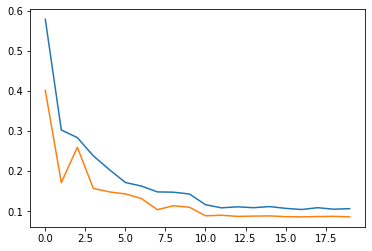

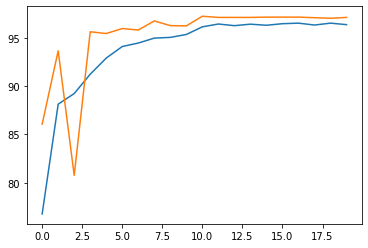

In [12]:
import torch.optim as optim
from torch.optim import lr_scheduler

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Makes multiple runs comparable
torch.manual_seed(42)
if haveCuda:
  torch.cuda.manual_seed(42)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

net = ConvNet(8)
if haveCuda:
  net = net.cuda()

# Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9,
                      nesterov=True, weight_decay=1e-4)

# Create LR cheduler
scheduler = lr_scheduler.StepLR(optimizer,10)

# Epoch counter
numEpoch = 20

trLosses = []
trAccs = []
valLosses = []
valAccs = []

for epoch in range(numEpoch):

  # Call train and val
  tr_loss,tr_corr = train(epoch)
  val_loss,val_corr = val(epoch)
  
  trLosses.append(tr_loss)
  trAccs.append(tr_corr)
  valLosses.append(val_loss)
  valAccs.append(val_corr)

  # Step with the scheduler
  scheduler.step()

# Finished
print('Finished Training')
plt.plot(trLosses)
plt.plot(valLosses)
plt.show()
plt.plot(trAccs)
plt.plot(valAccs)
plt.show()


## Confusion Matrix

In [13]:
net.eval()

conf = torch.zeros(5,5)

# Create progress bar
bar = display(progress(0, len(testLoader)), display_id=True)

# Epoch loop
for i, data in enumerate(testLoader, 0):
  # get the inputs
  inputs, labels = data

  # Convert to cuda conditionally
  if haveCuda:
      inputs, labels = inputs.cuda(), labels.cuda()

  # forward
  outputs = net(inputs)

  # compute statistics
  _, predicted = torch.max(outputs, 1)
  for label,pred in zip (labels,predicted):
    conf[label,pred] += 1

  # Update progress bar
  bar.update(progress(i+1, len(testLoader)))
print(conf)

tensor([[645.,   0.,   0.,   0.,  13.],
        [  0., 656.,   2.,   0.,   0.],
        [  2.,   2., 651.,   3.,   0.],
        [  0.,   0.,   0., 658.,   0.],
        [ 70.,   0.,   2.,   0., 586.]])


## Vizualizáció

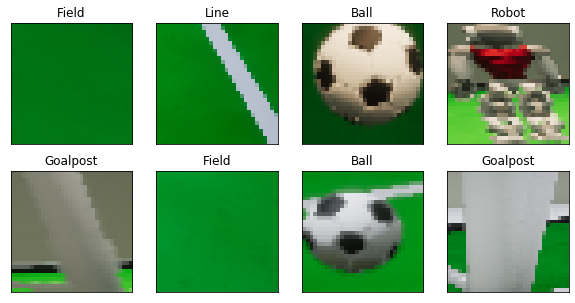

In [16]:
inputs, labels = next(iter(testLoader))
if haveCuda:
    inputs, labels = inputs.cuda(), labels.cuda()

# forward
outputs = net(inputs)

_, predicted = torch.max(outputs, 1)

mean = torch.Tensor((0.49139968, 0.48215827, 0.44653124)).unsqueeze(1).unsqueeze(1)
std = torch.Tensor((0.24703233, 0.24348505, 0.26158768)).unsqueeze(1).unsqueeze(1)

f, axarr = plt.subplots(2, 4,figsize=(10, 5))

for i,(img,pred) in enumerate(zip(inputs,predicted)):
    img_rescaled = img.cpu() * std + mean
    pr = pred.cpu().item()
    name = "Field" if pr == 0 else ("Ball" if pr == 1 else ("Robot" if pr == 2 else ("Goalpost" if pr == 3 else "Line")))
    
    axarr[i//4,i%4].imshow(img_rescaled.permute(1,2,0))
    axarr[i//4,i%4].set_title(name)
    # Hide grid lines
    axarr[i//4,i%4].grid(False)
    # Hide axes ticks
    axarr[i//4,i%4].set_xticks([])
    axarr[i//4,i%4].set_yticks([])
    if i == 7:
        break

# Extra feladat

## Cosine Annealing Ensemble

Train epoch 1 loss: 0.525 correct: 78.07


Test epoch 1 loss: 0.226 correct: 92.07
Best model in restart 0, saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 2 loss: 0.269 correct: 89.95


Test epoch 2 loss: 0.167 correct: 93.74
Best model in restart 0, saving


Train epoch 3 loss: 0.206 correct: 92.39


Test epoch 3 loss: 0.171 correct: 93.71


Train epoch 4 loss: 0.177 correct: 93.48


Test epoch 4 loss: 0.179 correct: 93.31


Train epoch 5 loss: 0.181 correct: 93.84


Test epoch 5 loss: 0.758 correct: 76.87


Train epoch 6 loss: 0.139 correct: 95.45


Test epoch 6 loss: 0.109 correct: 96.53
Best model in restart 0, saving


Train epoch 7 loss: 0.133 correct: 95.56


Test epoch 7 loss: 0.115 correct: 96.17


Train epoch 8 loss: 0.123 correct: 96.03


Test epoch 8 loss: 0.096 correct: 96.87
Best model in restart 0, saving


Train epoch 9 loss: 0.114 correct: 96.41


Test epoch 9 loss: 0.090 correct: 97.14
Best model in restart 0, saving


Train epoch 10 loss: 0.116 correct: 96.24


Test epoch 10 loss: 0.084 correct: 97.08


Train epoch 11 loss: 0.108 correct: 96.61


Test epoch 11 loss: 0.086 correct: 97.08


Train epoch 12 loss: 0.104 correct: 96.67


Test epoch 12 loss: 0.083 correct: 97.45
Best model in restart 0, saving


Train epoch 13 loss: 0.106 correct: 96.64


Test epoch 13 loss: 0.090 correct: 97.11


Train epoch 14 loss: 0.103 correct: 96.69


Test epoch 14 loss: 0.086 correct: 97.33


Train epoch 15 loss: 0.101 correct: 96.73


Test epoch 15 loss: 0.082 correct: 97.26


Train epoch 16 loss: 0.099 correct: 96.89


Test epoch 16 loss: 0.079 correct: 97.42
Best model in restart 1, saving


Train epoch 17 loss: 0.116 correct: 96.21


Test epoch 17 loss: 0.104 correct: 96.53


Train epoch 18 loss: 0.127 correct: 95.92


Test epoch 18 loss: 0.104 correct: 97.02


Train epoch 19 loss: 0.120 correct: 96.28


Test epoch 19 loss: 0.104 correct: 96.53


Train epoch 20 loss: 0.113 correct: 96.52


Test epoch 20 loss: 0.092 correct: 96.99


Train epoch 21 loss: 0.114 correct: 96.42


Test epoch 21 loss: 0.089 correct: 97.05


Train epoch 22 loss: 0.104 correct: 96.62


Test epoch 22 loss: 0.142 correct: 95.47


Train epoch 23 loss: 0.099 correct: 96.86


Test epoch 23 loss: 0.083 correct: 97.26


Train epoch 24 loss: 0.097 correct: 96.93


Test epoch 24 loss: 0.081 correct: 97.33


Train epoch 25 loss: 0.096 correct: 96.92


Test epoch 25 loss: 0.086 correct: 97.60
Best model in restart 1, saving


Train epoch 26 loss: 0.095 correct: 97.02


Test epoch 26 loss: 0.081 correct: 97.51


Train epoch 27 loss: 0.091 correct: 97.18


Test epoch 27 loss: 0.080 correct: 97.39


Train epoch 28 loss: 0.085 correct: 97.36


Test epoch 28 loss: 0.080 correct: 97.45


Train epoch 29 loss: 0.088 correct: 97.10


Test epoch 29 loss: 0.080 correct: 97.29


Train epoch 30 loss: 0.084 correct: 97.33


Test epoch 30 loss: 0.078 correct: 97.42


Train epoch 31 loss: 0.084 correct: 97.40


Test epoch 31 loss: 0.076 correct: 97.33
Best model in restart 2, saving


Train epoch 32 loss: 0.113 correct: 96.41


Test epoch 32 loss: 0.096 correct: 96.96


Train epoch 33 loss: 0.102 correct: 96.74


Test epoch 33 loss: 0.124 correct: 95.68


Train epoch 34 loss: 0.100 correct: 96.82


Test epoch 34 loss: 0.081 correct: 97.36
Best model in restart 2, saving


Train epoch 35 loss: 0.098 correct: 96.86


Test epoch 35 loss: 0.089 correct: 97.02


Train epoch 36 loss: 0.095 correct: 96.96


Test epoch 36 loss: 0.090 correct: 97.23


Train epoch 37 loss: 0.091 correct: 97.01


Test epoch 37 loss: 0.089 correct: 97.36


Train epoch 38 loss: 0.089 correct: 97.18


Test epoch 38 loss: 0.081 correct: 97.33


Train epoch 39 loss: 0.094 correct: 97.06


Test epoch 39 loss: 0.080 correct: 97.39
Best model in restart 2, saving


Train epoch 40 loss: 0.088 correct: 97.31


Test epoch 40 loss: 0.080 correct: 97.39


Train epoch 41 loss: 0.082 correct: 97.27


Test epoch 41 loss: 0.078 correct: 97.45
Best model in restart 2, saving


Train epoch 42 loss: 0.081 correct: 97.45


Test epoch 42 loss: 0.082 correct: 97.39


Train epoch 43 loss: 0.080 correct: 97.39


Test epoch 43 loss: 0.078 correct: 97.51
Best model in restart 2, saving


Train epoch 44 loss: 0.081 correct: 97.46


Test epoch 44 loss: 0.079 correct: 97.33


Train epoch 45 loss: 0.078 correct: 97.55


Test epoch 45 loss: 0.077 correct: 97.45


Train epoch 46 loss: 0.078 correct: 97.58


Test epoch 46 loss: 0.077 correct: 97.51
Best model in restart 3, saving


Train epoch 47 loss: 0.107 correct: 96.52


Test epoch 47 loss: 0.100 correct: 97.02


Train epoch 48 loss: 0.099 correct: 96.83


Test epoch 48 loss: 0.105 correct: 96.66


Train epoch 49 loss: 0.093 correct: 97.05


Test epoch 49 loss: 0.080 correct: 97.36


Train epoch 50 loss: 0.091 correct: 97.12


Test epoch 50 loss: 0.092 correct: 97.08


Train epoch 51 loss: 0.095 correct: 96.97


Test epoch 51 loss: 0.097 correct: 97.05


Train epoch 52 loss: 0.092 correct: 97.04


Test epoch 52 loss: 0.080 correct: 97.36


Train epoch 53 loss: 0.089 correct: 97.17


Test epoch 53 loss: 0.077 correct: 97.36


Train epoch 54 loss: 0.088 correct: 97.23


Test epoch 54 loss: 0.076 correct: 97.66
Best model in restart 3, saving


Train epoch 55 loss: 0.080 correct: 97.32


Test epoch 55 loss: 0.078 correct: 97.05


Train epoch 56 loss: 0.082 correct: 97.34


Test epoch 56 loss: 0.085 correct: 97.29


Train epoch 57 loss: 0.079 correct: 97.43


Test epoch 57 loss: 0.080 correct: 97.11


Train epoch 58 loss: 0.075 correct: 97.60


Test epoch 58 loss: 0.078 correct: 97.33


Train epoch 59 loss: 0.077 correct: 97.50


Test epoch 59 loss: 0.073 correct: 97.48


Train epoch 60 loss: 0.075 correct: 97.60


Test epoch 60 loss: 0.075 correct: 97.51
Finished Training


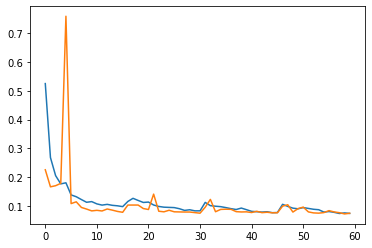

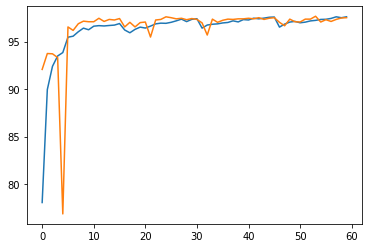

In [18]:
import torch.optim as optim
from torch.optim import lr_scheduler

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Makes multiple runs comparable
torch.manual_seed(42)
if haveCuda:
  torch.cuda.manual_seed(42)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

net = ConvNet(8)
if haveCuda:
  net = net.cuda()

# Loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9,
                      nesterov=True, weight_decay=1e-4)

# Create LR cheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,15,eta_min=1e-2)

# Epoch counter
numRest = 4
numEpoch = 15

trLosses = []
trAccs = []
valLosses = []
valAccs = []

restarts = -1
bestAccs = torch.zeros(numRest)

for epoch in range(numEpoch*numRest):
  
  # Every numEpoch epochs reset the sceduler
  currEp = None
  if (epoch % numEpoch) == 0:
    currEp = 0
    restarts += 1

  # Call train and val
  tr_loss,tr_corr = train(epoch)
  val_loss,val_corr = val(epoch)

  # Step with the scheduler
  scheduler.step(epoch=currEp)
  
  trLosses.append(tr_loss)
  trAccs.append(tr_corr)
  valLosses.append(val_loss)
  valAccs.append(val_corr)
  
  if bestAccs[restarts] < val_corr:
    bestAccs[restarts] = val_corr
    print("Best model in restart %d, saving" % restarts)
    torch.save(net,('/model%d.pth' % restarts))

# Finished
print('Finished Training')
plt.plot(trLosses)
plt.plot(valLosses)
plt.show()
plt.plot(trAccs)
plt.plot(valAccs)
plt.show()

## Validáció ensemble segítségével

In [19]:
accs = bestAccs
modelNum = 4
net = []
for i in range(modelNum):
  net.append( ConvNet(8).cuda() )
  state_dict = torch.load(("/model%d.pth" % i)).state_dict()
  net[i].load_state_dict(state_dict)
  net[i].eval()
  
conf = torch.zeros(5,5)
running_loss = 0.0
correct = 0.0
total = 0

# Create progress bar
bar = display(progress(0, len(testLoader)), display_id=True)

# Epoch loop
for i, data in enumerate(testLoader, 0):
  # get the inputs
  inputs, labels = data

  # Convert to cuda conditionally
  if haveCuda:
      inputs, labels = inputs.cuda(), labels.cuda()

  # forward
  outputs = accs[0]*net[0](inputs)
  for j in range(modelNum-1):
    outputs += accs[j+1]*net[j+1](inputs)
  loss = criterion(outputs, labels)

  # compute statistics
  running_loss += loss.item()
  _, predicted = torch.max(outputs, 1)
  total += labels.size(0)
  correct += predicted.eq(labels).sum().item()
  for label,pred in zip (labels,predicted):
    conf[label,pred] += 1

  # Update progress bar
  bar.update(progress(i+1, len(testLoader)))

val_loss = running_loss / len(testLoader)
val_corr = correct / total * 100
print("Test finished loss: %.3f correct: %.2f" % (val_loss, val_corr))
print(conf)

Test finished loss: 22.245 correct: 97.78
tensor([[653.,   0.,   0.,   0.,   5.],
        [  0., 657.,   1.,   0.,   0.],
        [  0.,   0., 656.,   1.,   1.],
        [  0.,   0.,   0., 658.,   0.],
        [ 63.,   0.,   2.,   0., 593.]])
